# Predicting yeilds.

In [ ]:
import batman
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

params = batman.TransitParams()       #object to store transit parameters
params.t0 = 0.                        #time of inferior conjunction
params.per = 1.                       #orbital period
params.rp = 0.1                       #planet radius (in units of stellar radii)
params.a = 15.                        #semi-major axis (in units of stellar radii)
params.inc = 87.                      #orbital inclination (in degrees)
params.ecc = 0.                       #eccentricity
params.w = 90.                        #longitude of periastron (in degrees)
params.limb_dark = "nonlinear"        #limb darkening model
params.u = [0.5, 0.1, 0.1, -0.1]      #limb darkening coefficients

t = np.linspace(-0.025, 0.025, 1000)  #times at which to calculate light curve
m = batman.TransitModel(params, t)    #initializes model
flux = m.light_curve(params)          #calculates light curve

plt.plot(t, flux, ".")

params = batman.TransitParams()       #object to store transit parameters
params.t0 = .001                        #time of inferior conjunction
params.per = 1.                       #orbital period
params.rp = 0.1                       #planet radius (in units of stellar radii)
params.a = 15.                        #semi-major axis (in units of stellar radii)
params.inc = 87.                      #orbital inclination (in degrees)
params.ecc = 0.                       #eccentricity
params.w = 90.                        #longitude of periastron (in degrees)
params.limb_dark = "nonlinear"        #limb darkening model
params.u = [0.5, 0.1, 0.1, -0.1]      #limb darkening coefficients

t = np.linspace(-0.025, 0.025, 1000)  #times at which to calculate light curve
m = batman.TransitModel(params, t)    #initializes model
flux = m.light_curve(params)          #calculates light curve

plt.plot(t, flux, ".")

There are 10^10 stars in the LMC and 5x10^9 stars in the SMC. The DEC detector has 62 chips, 4k x 4k. 16Mpixels. 10^5 stars per chip.

In [ ]:
Nstars = 10**5 * 62
Nstars

Around 0.2% of stars have hot Jupiters.

In [ ]:
NhotJs = .002 * Nstars
NhotJs

But not all of these will transit.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import batman
from tqdm import tqdm
from tqdm import trange
from astropy.stats import BoxLeastSquares
import astropy.constants as co
import astropy.units as u

plotpar = {'axes.labelsize': 20,
           'font.size': 20,
           'legend.fontsize': 20,
           'xtick.labelsize': 20,
           'ytick.labelsize': 20,
           'text.usetex': True}
plt.rcParams.update(plotpar)

In [ ]:
df = pd.read_csv("KOIs.csv", skiprows=53)
for i in df.keys():
    print(i)

Select G stars and remove false positives.

In [ ]:
m = df.koi_steff.values < 6000
m &= 5200 < df.koi_steff.values
m &= df.koi_pdisposition.values == "CANDIDATE"
m &= df.koi_disposition.values == "CONFIRMED"

m2 = df.koi_pdisposition.values == "CANDIDATE"
m2 &= df.koi_disposition.values == "CONFIRMED"

df_G = df.iloc[m]

In [ ]:
plt.loglog(df.koi_period.values[m2], df.koi_prad.values[m2], ".", alpha=.2, label="All hosts")
plt.loglog(df_G.koi_period, df_G.koi_prad, ".", label="G-type hosts")
plt.xlabel("Orbital period [days]")
plt.ylabel("Planet radius [R_Earth]")
plt.ylim(.5, 100)
plt.xlim(.4, 1000)
plt.legend()

In [ ]:
plt.loglog(df_G.koi_period, df_G.koi_depth, ".")
plt.xlabel("Orbital period [days]")
plt.ylabel("Depth")

In [ ]:
m = df_G.koi_period.values < 20
m &= np.log10(df_G.koi_depth) < 4.5
m &= 3 < np.log10(df_G.koi_depth)
plt.scatter(df_G.koi_period.values[m], np.log10(df_G.koi_depth.values[m]), 
            c=np.log10(df_G.koi_duration.values[m]), s=50)
plt.xlabel("Orbital period [days]")
plt.ylabel("Depth")
plt.ylim(3, 4.5)
plt.xlim(0, 20)
plt.colorbar(label="log10(Duration [hrs])")
print(sum(m))
print(len(df))

In [ ]:
plt.hist(df_G.koi_duration.values[m]);

In [ ]:
plt.hist(df_G.koi_steff);

In [ ]:
plt.hist(df_G.koi_slogg);

In [ ]:
print(len(df.iloc[df.koi_disposition.values=="CONFIRMED"]))

Calculate transit duration

In [ ]:
def duration(rstar, rp, b, a, P):
    """
    P: period in seconds
    rstar: stellar radius in m
    rp: planet radius in m
    a: semi-major axis in m
    """
    dt = P/np.pi * np.arcsin(np.sqrt( (rstar + rp)**2 - (b*rstar)**2 ) / a)
    return dt/3600

def kepler3(P, M):
    """
    period, P in days, mass (M) in Solar masses
    """
    p = 24*3600*P
    m = M * co.M_sun.value
    a = (co.G.value * m / (4*np.pi**2) * p**2)**(1./3)
    return a

In [ ]:
rstar = 1*co.R_sun.value
rp = .1*rstar
a = 1*co.au.value
period = 365.25  # days
b = 0.
print(duration(rstar, rp, 0, a, 3600*24*period))

a = kepler3(1, 1)
print(a/co.au.value, "AU")
print(duration(rstar, rp, 0, a, 3600*24*1))

Cadence is around 5 minutes, 23.5 magnitude, S/N = 10. Minimum number of nights needed to observe 1/2 of these.
4 nights in a row is the minimum requirement - but to find subgiants longer baselines are needed. 5% precision.

look at distribution of orbital periods of CVs. Durations are 5 - 10%. 

Simulate a light curve.

In [ ]:
import astropy.constants as co
import astropy.units as u

In [ ]:
period_days = 1.  # period in days
cadence_minutes = 5  # cadence in minutes
radius = 2 * co.R_jup/co.R_sun  # 1 Jupiter radius in stellar radii
precision = 5  # percent

In [ ]:
def make_light_curve(period_days, cadence_minutes, radius, precision, baseline=20):
    period_s = period_days * 24 * 3600
    period_s = period_s*u.s
    G = 6.67e-11
    M = 2e30
    a = (period_s**2*co.G*co.M_sun/(4*np.pi**2))**(1./3)/co.R_sun

    params = batman.TransitParams()       #object to store transit parameters
    params.t0 = 0.                        #time of inferior conjunction
    params.per = period_days # period_days                   #orbital period
    params.rp = radius                       #planet radius (in units of stellar radii)
    params.a = a # (period_s**2*G*M/(4*np.pi**2))/6.955e8  #semi-major axis (in units of stellar radii)
    params.inc = 90.                      #orbital inclination (in degrees)
    params.ecc = 0.                       #eccentricity
    params.w = 90.                        #longitude of periastron (in degrees)
    params.limb_dark = "nonlinear"        #limb darkening model
    params.u = [0.5, 0.1, 0.1, -0.1]      #limb darkening coefficients

    cadence = cadence_minutes/(24*60)  # 30 minute cadence in days
    t = np.arange(0, baseline, cadence)  #times at which to calculate light curve [days]
    m = batman.TransitModel(params, t)    #initializes model

    flux = m.light_curve(params)          #calculates light curve

    f = flux + np.random.randn(len(t))*precision*1e-2
    
    return t, f

In [ ]:
t, f = make_light_curve(period_days, cadence_minutes, radius, precision)
plt.plot(t, f, ".")

In [ ]:
from astropy.stats import BoxLeastSquares

model = BoxLeastSquares(t, f, dy=precision*1e-2)
periodogram = model.autopower(0.2)

In [ ]:
plt.plot(periodogram.period, periodogram.power)
plt.axvline(period_days, color="tab:orange", ls="--")

In [ ]:
print(periodogram.period[periodogram.power == max(periodogram.power)][0])

Now try a range of radii and orbital periods.

In [ ]:
Ntrials = 24
Norbs = 10
Nrads = 8
porbs = 10**(np.linspace(.01, np.log10(20), Norbs))
radii = np.linspace(.5, 2, Nrads)*co.R_jup/co.R_sun
recovered, true_p = [np.zeros((Norbs, Nrads, Ntrials)) for i in range(2)]

print("porbs = ", porbs)
print("radii = ", radii)

for k in tqdm(range(Ntrials)):
    for i in range(Norbs):
        for j in range(Nrads):
            t, f = make_light_curve(porbs[i], cadence_minutes, radii[j], precision)
            model = BoxLeastSquares(t, f, dy=precision*1e-2)
            periodogram = model.autopower(0.2)
            recovered[i, j, k] = periodogram.period[periodogram.power == max(periodogram.power)][0]
            true_p[i, j, k] = porbs[i]
            
            # Make plots
            plt.plot(periodogram.period, periodogram.power)
            plt.axvline(porbs[i], color="tab:orange", ls="--")
            plt.savefig("plots/{0}{1}{2}".format(i, j, k))
            plt.close()
            plt.plot(t, f, ".")
            plt.savefig("plots/{0}{1}{2}_lc".format(i, j, k))
            plt.close()

Were the recovered periods within 10% of the injected ones?

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

success = true_p/abs(true_p - recovered)
success_hist = np.zeros((Norbs, Nrads))

for i in range(Norbs):
    for j in range(Nrads):
        success = abs(true_p[i, j, :] - recovered[i, j, :])/true_p[i, j, :]
        s = success <= .1
        success_hist[i, j] = float(sum(s))/Ntrials
        
rjup = co.R_jup/co.R_sun

fig, ax = plt.subplots(figsize=(Nrads*1, Norbs*1))
img = ax.imshow(success_hist, extent=[radii[0]/rjup, radii[-1]/rjup, porbs[1], porbs[0]], aspect="auto")
tlabels = []
tmarks = np.linspace(porbs[0], 1.5, Norbs)
for p in porbs:
    tlabels.append("${0:.3}$".format(p))
ax.set_yticks(tmarks)
ax.set_yticklabels(tlabels)
plt.xlabel("$\mathrm{Planet~radius~[Jupiter~radii]}$")
plt.ylabel("$\mathrm{Orbital~period~[days]}$")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(img, ax=ax, cax=cax, label="$\mathrm{Fraction~recovered}$")
plt.subplots_adjust
plt.savefig("completeness.pdf")

# Now with a more realistic observing strategy (6 hours per night).

In [5]:
def make_light_curve_nights(period_days, radius, cadence_minutes, precision, 
                            baseline=9, interval=1, months=4, nights=True):
    assert radius <= 1., "The radius of your planet can't be greater than the radius of the star."
    
    period_s = period_days * 24 * 3600
    period_s = period_s*u.s
    G = 6.67e-11
    M = 2e30
    a = (period_s**2*co.G*co.M_sun/(4*np.pi**2))**(1./3)/co.R_sun

    params = batman.TransitParams()       #object to store transit parameters
    params.t0 = np.random.uniform(0, 20)  # 0.                 #time of inferior conjunction
    params.per = period_days # period_days                   #orbital period
    params.rp = radius                       #planet radius (in units of stellar radii)
    params.a = a # (period_s**2*G*M/(4*np.pi**2))/6.955e8  #semi-major axis (in units of stellar radii)
    params.inc = 90.                      #orbital inclination (in degrees)
    params.ecc = 0.                       #eccentricity
    params.w = 90.                        #longitude of periastron (in degrees)
    params.limb_dark = "nonlinear"        #limb darkening model
    params.u = [0.5, 0.1, 0.1, -0.1]      #limb darkening coefficients

    cadence = cadence_minutes/(24*60)  # 30 minute cadence in days
    t = np.arange(0, baseline + months*28, cadence)  #times at which to calculate light curve [days]
    
    if nights:
        ns = range(0, baseline, interval)  # the nights to observe
        times = []
        for k in range(months):
            for j in ns:
                n = 24*j + (28*24*k) < t*24
                n &= t*24 < 24*j + 6 + (28*24*k)
                times += list(t[n])
        t = np.array(times)
    
    m = batman.TransitModel(params, t)    #initializes model
    flux = m.light_curve(params)          #calculates light curve
#     flux = np.ones(len(t))
    f = flux + np.random.randn(len(t))*precision*1e-2
    return t, f

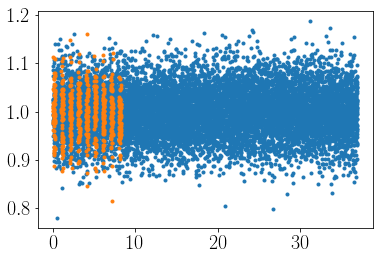

In [6]:
period_days = 1.  # period in days
cadence_minutes = 5  # cadence in minutes
radius = 1 * co.R_jup/co.R_sun  # 2 Jupiter radii in stellar radii
precision = 5  # percent

t, f = make_light_curve_nights(period_days, radius, cadence_minutes, precision, 
                               baseline=9, interval=1, months=1, nights=False)
plt.plot(t, f, ".")
t, f = make_light_curve_nights(period_days, radius, cadence_minutes, precision, 
                               baseline=9, interval=1, months=1, nights=True)
plt.plot(t, f, ".")

In [7]:
rjup = co.R_jup/co.R_sun

def run_bls(porbs, radii, cadence_minutes=5, precision=5, 
            baseline=9, interval=1, months=4,
            nights=False, threshold=15):
    
    N = len(porbs)
    recovered, maxpower, tces, t0 = [np.zeros((N)) for i in range(4)]
    for i in trange(N):
        t, f = make_light_curve_nights(porbs[i], radii[i], cadence_minutes, precision, 
                                       baseline=baseline, interval=interval, months=months,
                                       nights=nights)
        model = BoxLeastSquares(t, f, dy=precision*1e-2)
        periodogram = model.autopower(durations)
        
        index = periodogram.power == max(periodogram.power)
        
        t0[i] = periodogram.transit_time[index][0]
        recovered[i] = periodogram.period[index][0]
        maxpower[i] = max(periodogram.power)
        if maxpower[i] > threshold:
            tces[i] = 1
        
        # Make periodogram plot
        plt.plot(periodogram.period, periodogram.power)
        plt.axvline(porbs[i], color="tab:orange", ls="--")
        plt.title("{}".format(radii[i]/rjup))
        plt.savefig("plots/{0}".format(str(i).zfill(4)))
        plt.close()
        
        # Make lc plot
        plt.plot(t, f, ".")
        plt.title("{}".format(radii[i]/rjup))
        plt.savefig("plots/{0}_lc".format(str(i).zfill(4)))
        plt.close()
        
        # Make folded lc plot
        period = recovered[i]
        plt.plot((t - t0[i] + 0.5*period) % period - 0.5*period, f, ".")
        plt.title("{}".format(radii[i]/rjup))
        plt.savefig("plots/{0}_fold".format(str(i).zfill(4)))
        plt.close()
        
    return recovered, maxpower, tces, t0

In [17]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def make_plot(recovered, tces, porbs, radii):

    success = abs(porbs - recovered)/porbs
    success_m = success < .05 
    success_m &= tces == 1
    recovered_p, recovered_r = porbs[success_m], radii[success_m]
    print(len(recovered_p), "recovered planets")
    print(len(recovered_r[recovered_r/rjup < 1.]), "planets smaller than Jupiter")
    
    H_true, xedges, yedges = np.histogram2d(np.log10(porbs), radii/rjup, bins=5)
    H_recovered, _, _ = np.histogram2d(np.log10(recovered_p), recovered_r/rjup, bins=(xedges, yedges))
    H = H_recovered/H_true
    X, Y = np.meshgrid(xedges, yedges)
    
    plt.figure(figsize=(16, 9))
    plt.scatter(np.log10(porbs), radii/rjup, facecolors="None", edgecolors="tab:orange", s=20, zorder=2)
    plt.scatter(np.log10(recovered_p), recovered_r/rjup, color="tab:orange", s=20, zorder=3)
#     plt.plot(np.log10(recovered_p), recovered_r/rjup, ".", color="tab:blue", ms=3)
    plt.pcolormesh(X, Y, H.T, vmin=0., vmax=1., zorder=1)
    plt.xlabel("$\log_{10}(\mathrm{Orbital~Period~[days]})$")
    plt.ylabel("$\mathrm{Planet~Radius~[R_J]}$")
    plt.colorbar(label="$\mathrm{Fraction~Recovered}$")
    plt.xlim(-1, np.log10(20))
    plt.ylim(.5, 2)
    plt.savefig("completeness.pdf")
    return H

In [9]:
N = 1000
porbs = 10**(np.random.uniform(-1, np.log10(20), N))
radii = np.random.uniform(.5, 2, N)*rjup

In [ ]:
rstar = 1*co.R_sun.value
min_radius, max_radius = .5*co.R_jup.value, 3*co.R_jup.value
min_a, max_a = kepler3(min(porbs), 1), kepler3(max(porbs), 1)
min_period, max_period = min(porbs), max(porbs)
min_b, max_b = .01, .8
min_b, max_b = 0., 0.
# print("longest duration = ", duration(rstar, max_radius, min_b, min_a, 3600*24*max_period))
# print("shortest duration = ", duration(rstar, min_radius, max_b, max_a, 3600*24*min_period))

# durations = np.linspace(0.3, 17, 5)/24
durations = np.linspace(0.05, 0.2, 10)  # days

# Test intervals

18 nights over two months.

In [ ]:
import time
start = time.time()
recovered, maxpower, tces, t0 = run_bls(porbs, radii, cadence_minutes=3, precision=7, 
                                        baseline=9, interval=1, months=2, nights=True)
end = time.time()
print((end - start)/60, "minutes")
# recovered, maxpower, tces, t0 = run_bls(porbs, radii, cadence_minutes=3, precision=7, baseline=20, nights=False)

In [ ]:
H = make_plot(recovered, tces, porbs, radii)
print(H.T)

18 nights over 4 months (every other night)

In [ ]:
start = time.time()
recovered2, maxpower2, tces2, t02 = run_bls(porbs, radii, cadence_minutes=3, precision=7, 
                                            baseline=9, interval=2, months=4, nights=True)
end = time.time()
print((end - start)/60, "minutes")

In [ ]:
H2 = make_plot(recovered2, tces2, porbs, radii)
print(H2.T)

In [ ]:
start = time.time()
recovered3, maxpower3, tces3, t03 = run_bls(porbs, radii, cadence_minutes=3, precision=7, 
                                            baseline=9, interval=3, months=4, nights=True)
end = time.time()
print((end - start)/60, "minutes")

180 sec (3 min)   7%

300 sec (5 min) 5.3%

480 sec (8 min) 4.2%

600 sec (10 min) 3.8%

# Test cadences.

In [ ]:
start = time.time()
recovered_3min, maxpower_3min, tces_3min, t0_3min = run_bls(porbs, radii, cadence_minutes=3, precision=7, 
                                                            baseline=9, interval=1, months=1, nights=True)
end = time.time()
print((end - start)/60, "minutes")

In [ ]:
H_3min = make_plot(recovered_3min, tces_3min, porbs, radii)
print(H_3min.T)

In [11]:
import time
durations = np.linspace(0.05, 0.2, 10)  # days
start = time.time()
recovered_5min, maxpower_5min, tces_5min, t0_5min = run_bls(porbs, radii, cadence_minutes=5, precision=5.3, 
                                        baseline=9, interval=1, months=1, nights=True)
end = time.time()
print((end - start)/60, "minutes")

100%|██████████| 1000/1000 [15:41<00:00,  1.04it/s]

15.687840167681376 minutes


37 recovered planets
1 planets smaller than Jupiter
[[0.         0.02380952 0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.06451613 0.         0.         0.        ]
 [0.         0.20930233 0.05555556 0.         0.        ]
 [0.         0.43589744 0.15789474 0.         0.        ]]


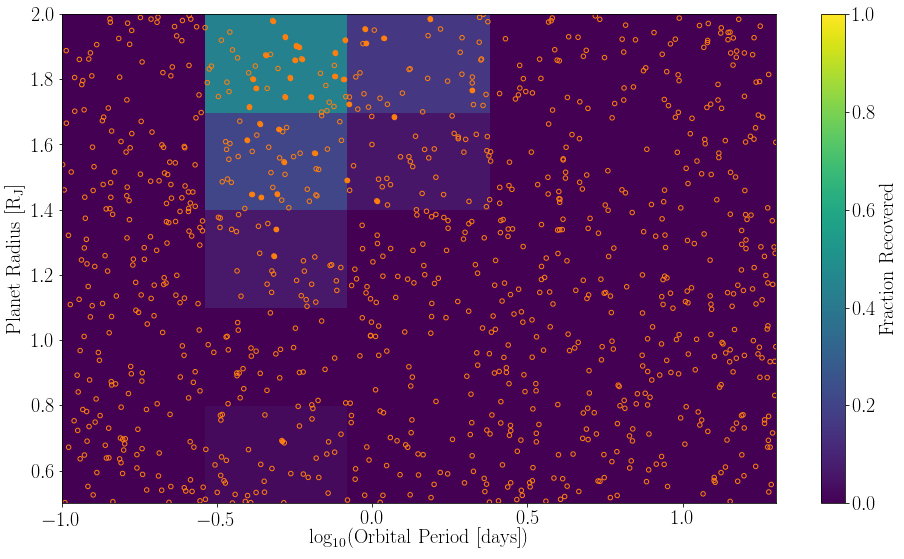

In [18]:
H_5min = make_plot(recovered_5min, tces_5min, porbs, radii)
print(H_5min.T)

In [ ]:
start = time.time()
recovered_8min, maxpower_8min, tces_8min, t0_8min = run_bls(porbs, radii, cadence_minutes=8, precision=4.2, 
                                        baseline=9, interval=1, months=1, nights=True)
end = time.time()
print((end - start)/60, "minutes")

In [ ]:
H_8min = make_plot(recovered_8min, tces_8min, porbs, radii)
print(H_8min.T)

In [ ]:
start = time.time()
recovered_10min, maxpower_10min, tces_10min, t0_10min = run_bls(porbs, radii, cadence_minutes=10, precision=3.8, 
                                        baseline=9, interval=1, months=1, nights=True)
end = time.time()
print((end - start)/60, "minutes")

In [ ]:
H_10min = make_plot(recovered_10min, tces_10min, porbs, radii)
print(H_10min.T)